In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize, minimize_scalar

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [4]:
system = trijunction.Trijunction(config)

In [5]:
system.make_system()

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


In [6]:
pair = 'left-right'
voltages = parameters.pair_voltages()

In [7]:
zero_potential = dict(
    zip(
        ta.array(system.site_coords[:, [0, 1]] - system.offset),
        np.zeros(len(system.site_coords)),
    )
)

In [8]:
kwant_args = list(system.optimiser_arguments().values())
kwant_args[-1] = kwant_args[-1][order_wavefunctions(pair)]

In [9]:
x = [-3.0e-3, -3.0e-3, -7.0e-3, 3e-3]
voltages = parameters.voltage_dict(x)

In [97]:
params = parameters.junction_parameters()
params.update(voltages)
params.update(potential=zero_potential)

In [11]:
opt_args = tuple([pair, params, kwant_args])

In [34]:
%%time

sol = minimize_scalar(
    codes.optimization.loss,
    0.2, 
    args=opt_args, 
    bounds=(0, 2), 
    method="bounded"
)

CPU times: user 46.9 s, sys: 11.7 s, total: 58.6 s
Wall time: 58.5 s


In [35]:
sol.x

1.371604030156733

In [36]:
optimal_phase = parameters.phase_pairs(opt_args[0], 
                                       sol.x * np.pi)

In [37]:
optimal_phase

{'phi1': 4.309021144774546, 'phi2': 0}

In [214]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [146]:
# loss to optimize voltages
params.update(optimal_phase)

In [229]:
import codes.utils
importlib.reload(codes.utils)

<module 'codes.utils' from '/home/tinkerer/trijunction-design/analysis/codes/utils.py'>

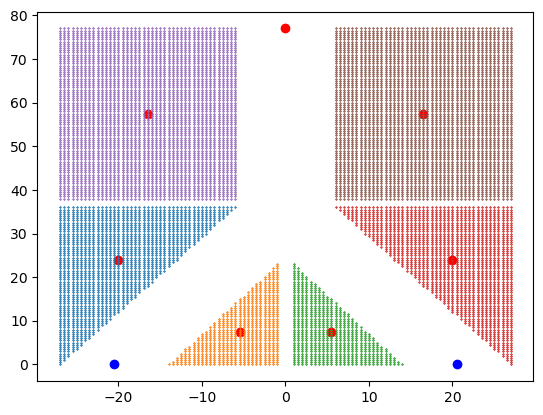

In [218]:
dep_index, acc_index = codes.utils.dep_acc_index(
            system.poisson_system,
            system.site_indices,
            system.nw_centers,
            pair,
            True
        )
params.update({'dep_index': dep_index})
params.update({'acc_index': acc_index})

In [219]:
opt_args = tuple([pair, params, kwant_args])
codes.optimization.loss(x, *opt_args)

0.526291648292613

In [47]:
sol1 = minimize(
            codes.optimization.loss,
            x,
            # minimizer_kwargs={'method': 'BFGS',
            #                   'args' : opt_args,
            #                   'options': {'gtol': 1e-1}},
            # disp = True
            args=opt_args,
            method="BFGS",
            options={
                "verbose": 2,
                # "initial_tr_radius": 1e-3,
                # "gtol": 1e-1,
            },
        )

/tmp/ipykernel_47139/1571957706.py:1: OptimizeWarning: Unknown solver options: verbose
  sol1 = minimize(


In [17]:
from scipy.optimize import approx_fprime

In [220]:
def gradient_descent(gradient, initial, learn_rate=0.5, 
                     beta1=0.9, beta2=0.999,
                     tolerance=1e-6, epsilon = 1e-8, n_iter=20):
    vector = initial
    diff, A, F = 0, 0, 0
    
    cost = []
    
    for i in range(n_iter):
        g = gradient(vector)
        print(g)
        
        # Momentum based learning
        # diff = decay_rate * diff - learn_rate * g
        
        # Adam gradient
        A = beta1 * A + (1 - beta1) * (g**2)
        F = beta2 * F + (1 - beta2) * (g)
        Ahat = A / (1 - beta1**(i+1))
        Fhat = F / (1 - beta2**(i+1))
        
        # learn_rate *= (np.sqrt(1 - beta1**(i+1)) / (1 - beta2**(i+1)))
        vector -= (learn_rate * Fhat)/(np.sqrt(Ahat) + epsilon)  # epsilon for better conditioning
        
        # if np.all(np.abs(diff) <= tolerance):
        #     break
        # diff = -learn_rate * g
        # vector += diff
        cost.append(codes.optimization.loss(vector, *opt_args))
        print(cost, vector)
        print('---------')
    return vector

In [221]:
x

[-0.003, -0.003, -0.007, 0.003]

In [222]:
gradient = lambda x: approx_fprime(x, codes.optimization.loss, 1e-3, *opt_args)

In [223]:
sol = gradient_descent(
    gradient, 
    x, 
    learn_rate=0.1, 
    beta1=0.9, beta2=0.9,
    tolerance=1e-9
)

[-0.0185432  -0.01937316 -0.62959072 -0.33249292]
[0.4262916522926111] [0.09699995 0.09699995 0.093      0.103     ]
---------
[-0.0185432  -0.01937316 -0.62959072 -0.33249292]
[0.4262916522926111, 0.32629165629260914] [0.19699989 0.1969999  0.193      0.20299999]
---------
[-0.0185432  -0.01937316 -0.62959072 -0.33249292]
[0.4262916522926111, 0.32629165629260914, 0.08585943418350983] [0.29699984 0.29699985 0.293      0.30299999]
---------


KeyboardInterrupt: 

In [224]:
params.update(parameters.voltage_dict([0.003, 0.003, 0.007, -0.003]))
opt_args = tuple([pair, params, kwant_args])

In [225]:
optimiser_args = system.optimiser_arguments()

numerical_hamiltonian = hamiltonian(system.trijunction, 
                                    optimiser_args['linear_terms'], 
                                    optimiser_args['kwant_params_fn'], 
                                    **params)

[-20.5   0.    0. ]
[20.5  0.   0. ]
[ 0. 77.  0.]
[-20.  24.   0.]
[-5.5  7.5  0. ]
[5.5 7.5 0. ]
[20. 24.  0.]
[-16.5  57.5   0. ]
[16.5 57.5  0. ]


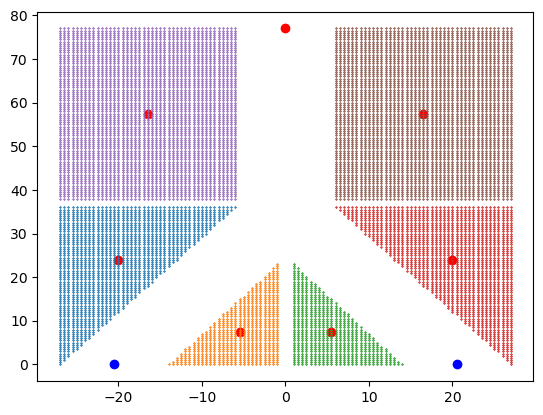

In [230]:
dep_index, acc_index = codes.utils.dep_acc_index(
            system.poisson_system,
            system.site_indices,
            system.nw_centers,
            pair,
            True
        )

In [231]:
ham = numerical_hamiltonian
loss = 0
for index in np.hstack(list(params['dep_index'].values())):
    diff = ham[4*index, 4*index] - params['mus_nw'][0]
    
    loss += diff if diff < 0 else 0

for index in np.hstack(list(params['acc_index'].values())):
    diff = ham[4*index, 4*index] - params['mus_nw'][0]
    print(diff)
    loss += diff if diff > 0 else 0

(0.2601861112242862+0j)
(0.25905872631010074+0j)


In [155]:
energies, wave_functions = eigsh(
                numerical_hamiltonian.tocsc(),
                6,
                sigma=0,
                return_eigenvectors=True,
)

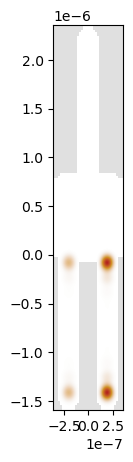

In [156]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5), sharey= True)

density = kwant.operator.Density(system.trijunction, np.eye(4))
for i, vec in enumerate(wave_functions.T[[0]]):
    kwant.plotter.density(system.trijunction, density(vec), ax = ax);

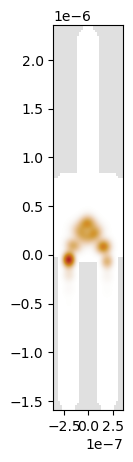

In [130]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5), sharey= True)

density = kwant.operator.Density(system.trijunction, np.eye(4))
for i, vec in enumerate(wave_functions.T[[0]]):
    kwant.plotter.density(system.trijunction, density(vec), ax = ax);

In [144]:
transformed_hamiltonian = svd_transformation(
    energies, wave_functions, system.mlwf[order_wavefunctions('left-right')]
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

In [145]:
desired

3.420274824242966e-05

In [139]:
desired

2.9545587357400678e-05